In [2]:
import numpy as np
import matplotlib.pyplot as plt
from lm_polygraph.ue_metrics.pred_rej_area import PredictionRejectionArea
from lm_polygraph.ue_metrics.ue_metric import (
    get_random_scores,
    normalize_metric,
)
import sklearn
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from collections import defaultdict
from sacrebleu import CHRF, BLEU
from utils import extract_and_prepare_data

/home/maiya.goloburda/.conda/envs/detrend/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/maiya.goloburda/.conda/envs/detrend/lib/python3.10/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
methods_dict = {
    'MaximumSequenceProbability': 'MSP',
    'Perplexity': 'PPL',
    'MeanTokenEntropy': 'MTE',
    # 'MeanPointwiseMutualInformation': 'MPMI',
    # 'MeanConditionalPointwiseMutualInformation': 'MCPMI',
    # 'PTrue': 'PTrue',
    # 'PTrueSampling': 'PTrueS',
    'MonteCarloSequenceEntropy': 'MCSE',
    'MonteCarloNormalizedSequenceEntropy': 'MCNSE',
}

DATASETS = [
    'wmt14_csen',
    # 'wmt14_deen',
    'wmt14_ruen',
    # 'wmt14_fren',
    # 'wmt19_deen',
    # 'wmt19_fien',
    # 'wmt19_lten',
    # 'wmt19_ruen',
]

all_metrics = ['Comet', 'BLEU']

Loading NLI model...


/home/maiya.goloburda/.conda/envs/detrend/lib/python3.10/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Initializing stat calculators...
Initializing InitialStateCalculator
Initializing SemanticMatrixCalculator
Initializing SemanticClassesCalculator
Initializing GreedyProbsCalculator

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7ff185192f80>]


Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Initializing stat calculators...
Initializing InitialStateCalculator
Initializing SemanticMatrixCalculator
Initializing SemanticClassesCalculator
Initializing GreedyProbsCalculator
Initializing EntropyCalculator
Initializing GreedyLMProbsCalculator
Initializing SamplingGenerationCalculator
Initializing BartScoreCalculator
Initializing ModelScoreCalculat

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7ff1847a7310>]


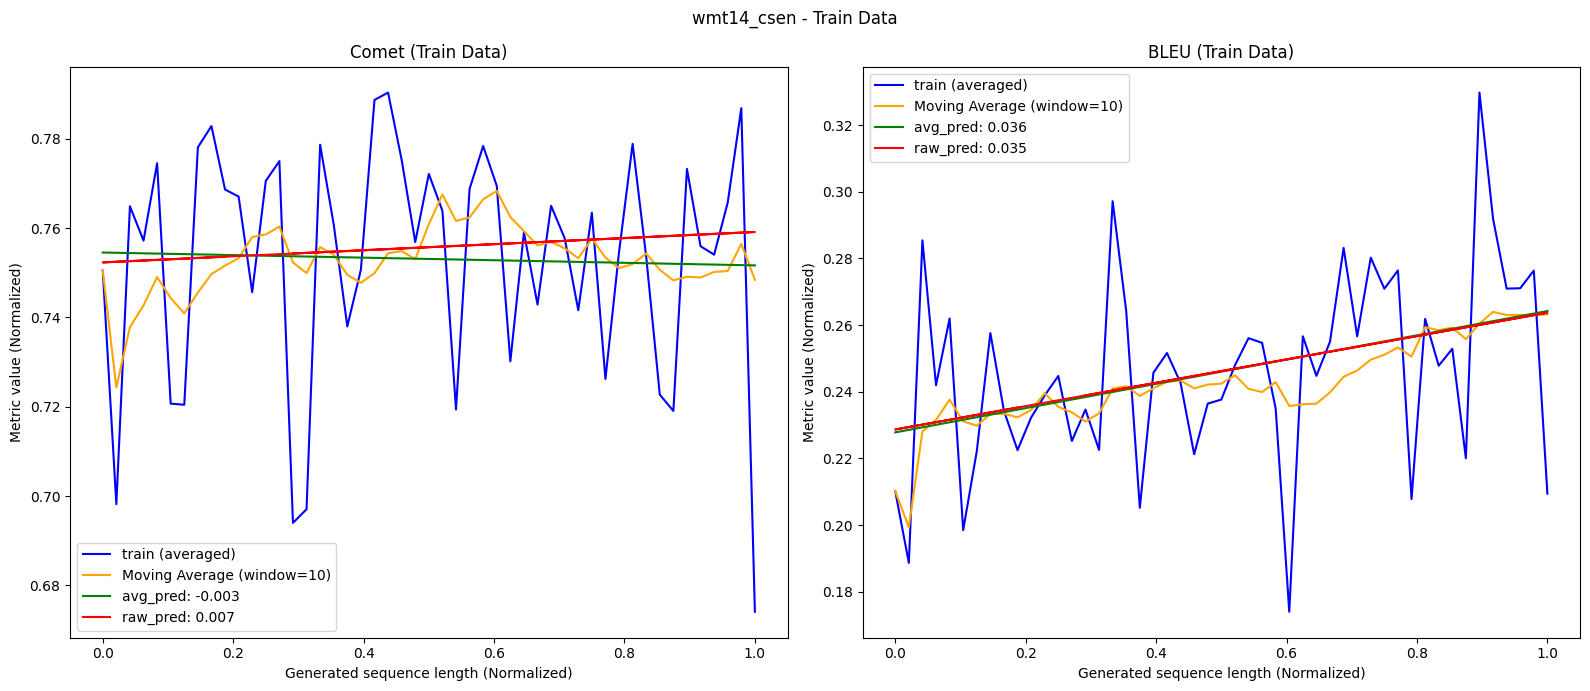

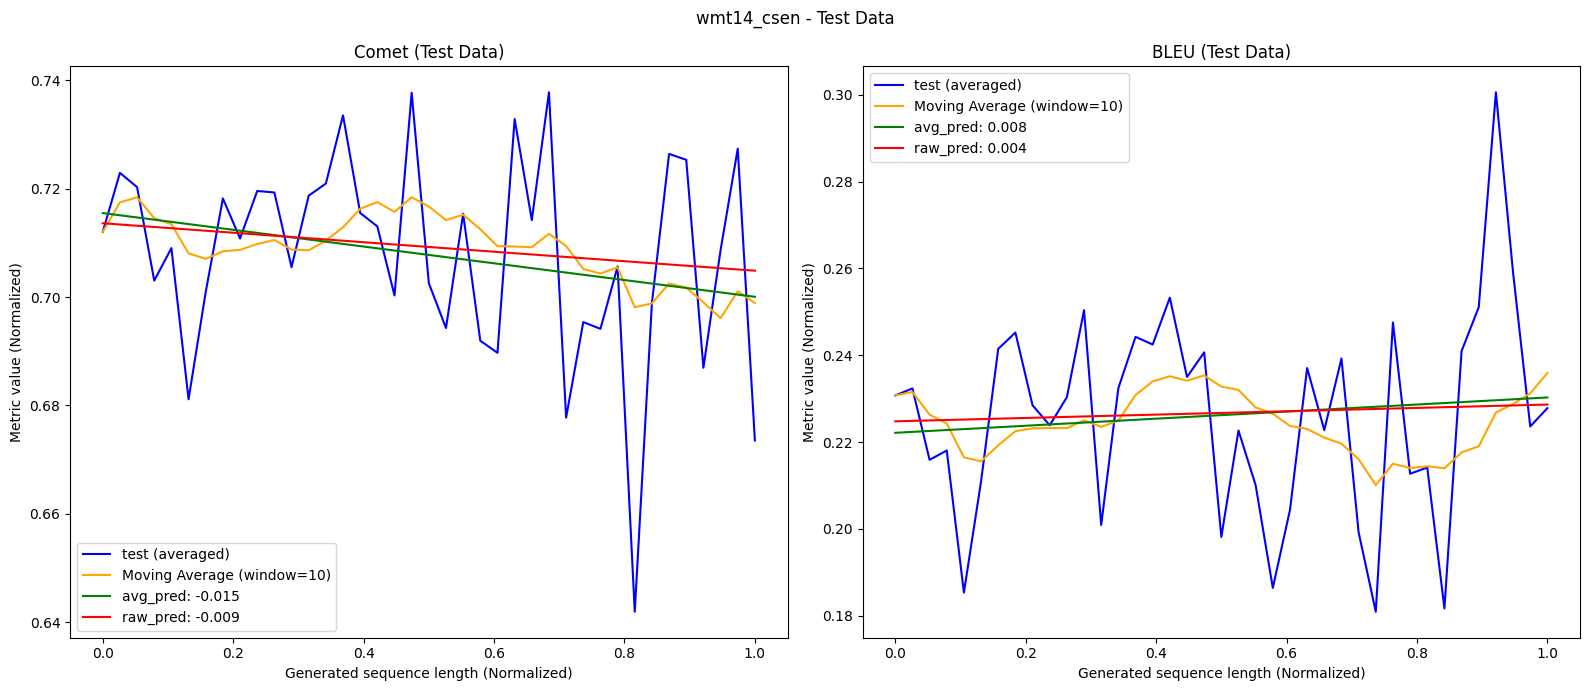

Loading NLI model...
/home/maiya.goloburda/.conda/envs/detrend/lib/python3.10/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Initializing stat calculators...
Initializing InitialStateCalculator
Initializing SemanticMatrixCalculator
Initializing SemanticClassesCalculator
Initializing 

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7ff1853df820>]


Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Initializing stat calculators...
Initializing InitialStateCalculator
Initializing SemanticMatrixCalculator
Initializing SemanticClassesCalculator
Initializing GreedyProbsCalculator
Initializing EntropyCalculator
Initializing GreedyLMProbsCalculator
Initializing SamplingGenerationCalculator
Initializing BartScoreCalculator
Initializing ModelScoreCalculat

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7ff179024970>]


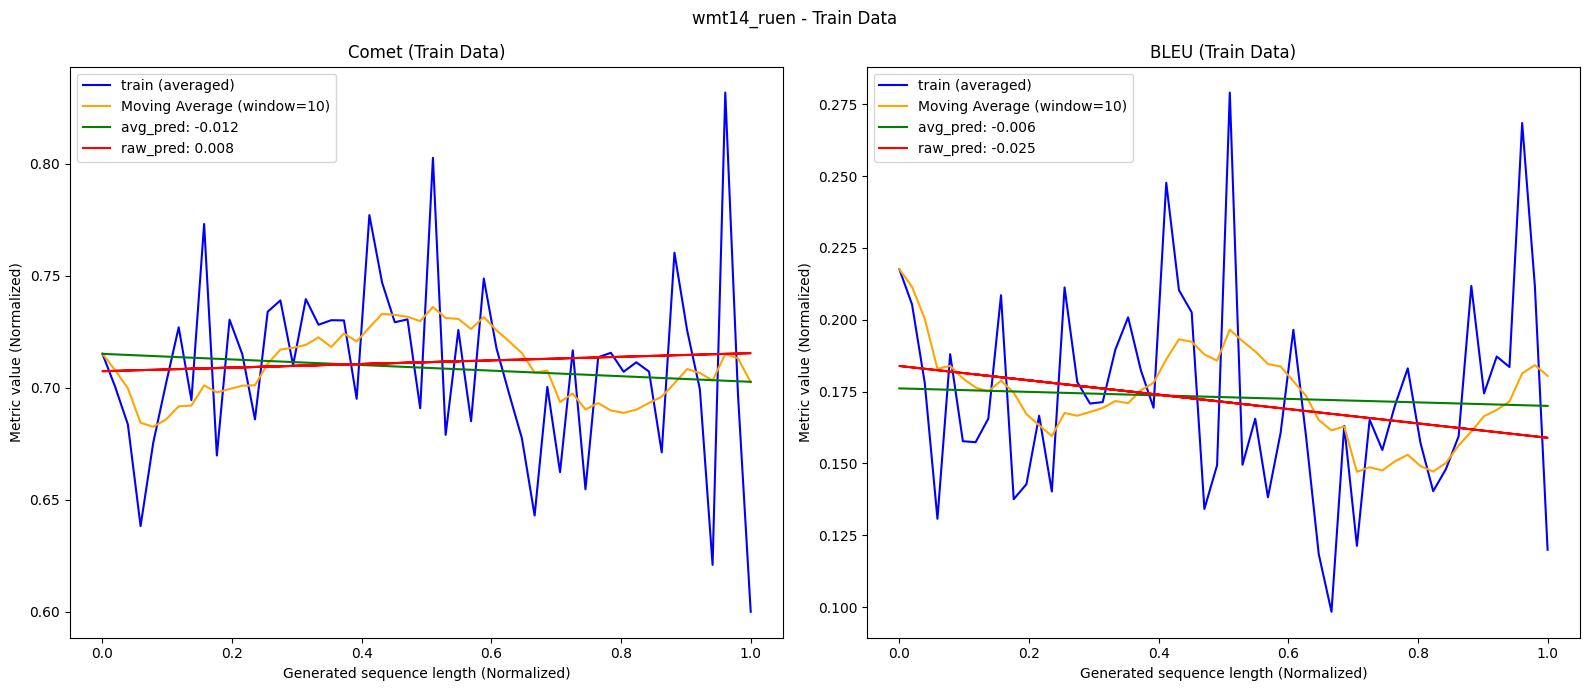

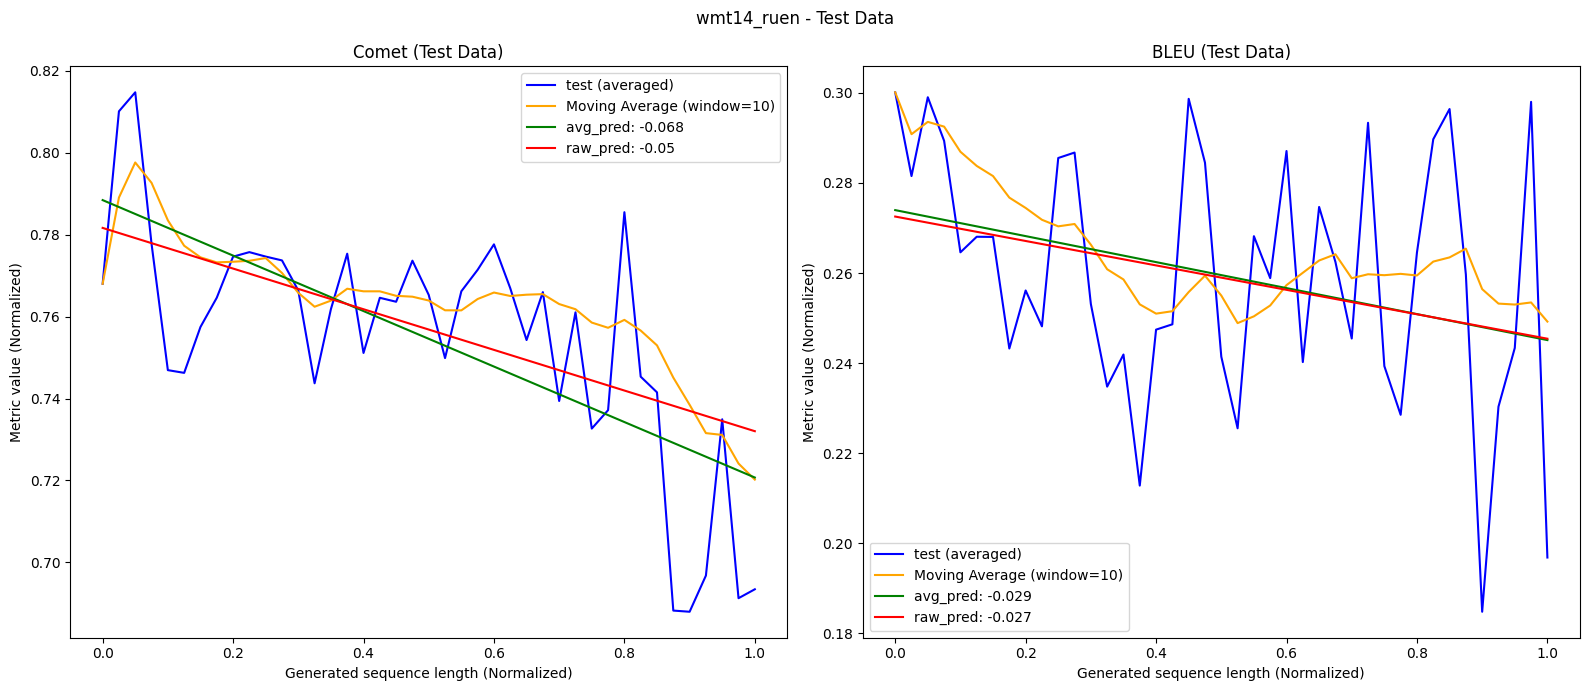

In [17]:
for dataset in DATASETS:
    train_ue_values, \
    test_ue_values, \
    train_metric_values, \
    test_metric_values, \
    train_gen_lengths, \
    test_gen_lengths = extract_and_prepare_data(dataset, methods_dict, all_metrics, model='llama1b')

    upper_q = np.quantile(train_gen_lengths, 0.95)
    lower_q = np.quantile(train_gen_lengths, 0.05)
    below_q_ids = (train_gen_lengths < upper_q) & (train_gen_lengths > lower_q)
    train_gen_lengths = train_gen_lengths[below_q_ids]

    train_normalized_metric_values = {}
    test_normalized_metric_values = {}

    # Train Data Plot
    fig, axs = plt.subplots(1, len(all_metrics), figsize=(8 * len(all_metrics), 7))
    
    for i, metric in enumerate(all_metrics):
        gen_length_scaler = MinMaxScaler()
        train_gen_lengths_normalized = gen_length_scaler.fit_transform(train_gen_lengths[:, np.newaxis]).squeeze()

        # Normalize train metrics
        train_metric = train_metric_values[metric][below_q_ids]
        scaler = MinMaxScaler()
        train_normalized_metric_values[metric] = scaler.fit_transform(train_metric[:, np.newaxis]).squeeze()

        # Average values for each unique generated sequence length
        unique_lengths = np.unique(train_gen_lengths_normalized)
        avg_train_metric_values = []
        avg_train_gen_lengths_normalized = []

        for length in unique_lengths:
            idx = np.isclose(train_gen_lengths_normalized, length)
            avg_train_metric_values.append(np.mean(train_normalized_metric_values[metric][idx]))
            avg_train_gen_lengths_normalized.append(length)

        avg_train_metric_values = np.array(avg_train_metric_values)
        avg_train_gen_lengths_normalized = np.array(avg_train_gen_lengths_normalized)

        # Compute moving average
        window_size = 10
        moving_avg = pd.Series(avg_train_metric_values).rolling(window=window_size, min_periods=1).mean()

        # Fit linear regression on averaged values
        train_linreg = sklearn.linear_model.LinearRegression()
        train_linreg.fit(avg_train_gen_lengths_normalized[:, np.newaxis], avg_train_metric_values)
        coef = train_linreg.coef_[0]

        # Fit linear regression on non-averaged data (raw data)
        raw_linreg = sklearn.linear_model.LinearRegression()
        raw_linreg.fit(train_gen_lengths_normalized[:, np.newaxis], train_normalized_metric_values[metric])

        ax = axs[i]
        ax.plot(avg_train_gen_lengths_normalized, avg_train_metric_values, label='train (averaged)', color='blue')
        ax.plot(avg_train_gen_lengths_normalized, moving_avg, label=f'Moving Average (window={window_size})', color='orange')
        ax.plot(avg_train_gen_lengths_normalized, train_linreg.predict(avg_train_gen_lengths_normalized[:, np.newaxis]), label=f'avg_pred: {round(coef, 3)}', color='green')
        ax.plot(train_gen_lengths_normalized, raw_linreg.predict(train_gen_lengths_normalized[:, np.newaxis]), label=f'raw_pred: {round(raw_linreg.coef_[0], 3)}', color='red')

        ax.legend()
        ax.set_title(f'{metric} (Train Data)')
        ax.set_xlabel('Generated sequence length (Normalized)')
        ax.set_ylabel('Metric value (Normalized)')

    fig.suptitle(f'{dataset} - Train Data')
    plt.tight_layout()
    plt.show()

    upper_q_test = np.quantile(test_gen_lengths, 0.95)
    lower_q_test = np.quantile(test_gen_lengths, 0.05)
    below_q_ids_test = (test_gen_lengths < upper_q_test) & (test_gen_lengths > lower_q_test)
    test_gen_lengths = test_gen_lengths[below_q_ids_test]


    # Test Data Plot (Separate figure)
    fig, axs = plt.subplots(1, len(all_metrics), figsize=(8 * len(all_metrics), 7))
    for i, metric in enumerate(all_metrics):
    # Normalize test sequence lengths using a separate MinMaxScaler for test data
        test_gen_length_scaler = MinMaxScaler()
        test_gen_lengths_normalized = test_gen_length_scaler.fit_transform(test_gen_lengths[:, np.newaxis]).squeeze()

        # Normalize test metrics using a new scaler for test data
        test_metric = test_metric_values[metric][below_q_ids_test]
        scaler_test = MinMaxScaler()
        test_normalized_metric_values[metric] = scaler_test.fit_transform(test_metric[:, np.newaxis]).squeeze()

        # Average values for each unique generated sequence length in the test data
        unique_lengths = np.unique(test_gen_lengths_normalized)
        avg_test_metric_values = []
        avg_test_gen_lengths_normalized = []

        for length in unique_lengths:
            idx = np.isclose(test_gen_lengths_normalized, length)
            avg_test_metric_values.append(np.mean(test_normalized_metric_values[metric][idx]))
            avg_test_gen_lengths_normalized.append(length)

        avg_test_metric_values = np.array(avg_test_metric_values)
        avg_test_gen_lengths_normalized = np.array(avg_test_gen_lengths_normalized)

        # Compute moving average for test data
        moving_avg_test = pd.Series(avg_test_metric_values).rolling(window=window_size, min_periods=1).mean()

        # Fit linear regression on averaged values for test data
        test_linreg = sklearn.linear_model.LinearRegression()
        test_linreg.fit(avg_test_gen_lengths_normalized[:, np.newaxis], avg_test_metric_values)
        coef = test_linreg.coef_[0]

        # Fit linear regression on non-averaged (raw) test data
        raw_linreg_test = sklearn.linear_model.LinearRegression()
        raw_linreg_test.fit(test_gen_lengths_normalized[:, np.newaxis], test_normalized_metric_values[metric])

        ax = axs[i]
        ax.plot(avg_test_gen_lengths_normalized, avg_test_metric_values, label='test (averaged)', color='blue')
        ax.plot(avg_test_gen_lengths_normalized, moving_avg_test, label=f'Moving Average (window={window_size})', color='orange')
        ax.plot(avg_test_gen_lengths_normalized, test_linreg.predict(avg_test_gen_lengths_normalized[:, np.newaxis]), label=f'avg_pred: {round(coef, 3)}', color='green')
        ax.plot(avg_test_gen_lengths_normalized, raw_linreg_test.predict(avg_test_gen_lengths_normalized[:, np.newaxis]), label=f'raw_pred: {round(raw_linreg_test.coef_[0], 3)}', color='red')

        ax.legend()
        ax.set_title(f'{metric} (Test Data)')
        ax.set_xlabel('Generated sequence length (Normalized)')
        ax.set_ylabel('Metric value (Normalized)')

    fig.suptitle(f'{dataset} - Test Data')
    plt.tight_layout()
    plt.show()



Loading NLI model...


/home/maiya.goloburda/.conda/envs/detrend/lib/python3.10/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Initializing stat calculators...
Initializing InitialStateCalculator
Initializing SemanticMatrixCalculator
Initializing SemanticClassesCalculator
Initializing GreedyProbsCalculator

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7ff1840b8b80>]


Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Initializing stat calculators...
Initializing InitialStateCalculator
Initializing SemanticMatrixCalculator
Initializing SemanticClassesCalculator
Initializing GreedyProbsCalculator
Initializing EntropyCalculator
Initializing GreedyLMProbsCalculator
Initializing SamplingGenerationCalculator
Initializing BartScoreCalculator
Initializing ModelScoreCalculat

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7ff130f60c40>]


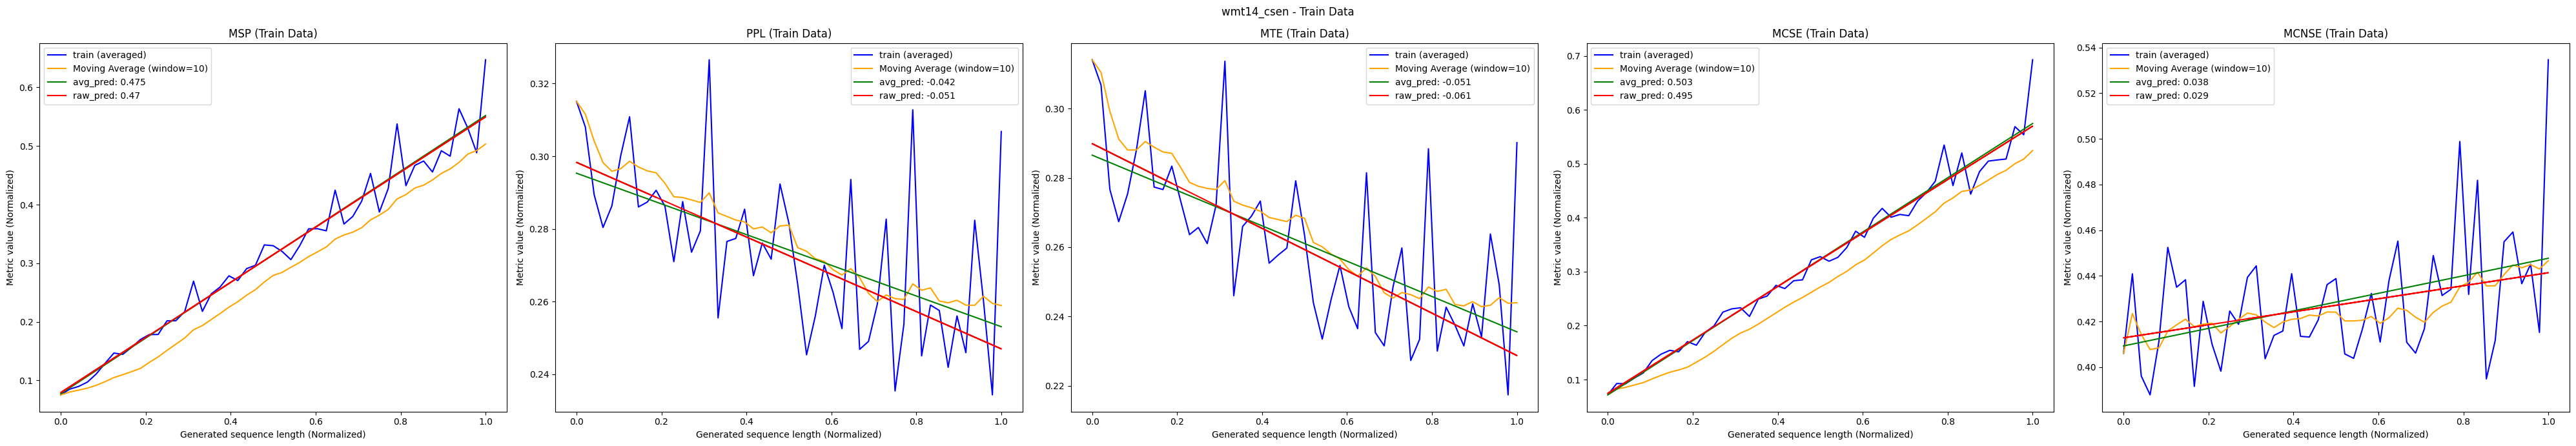

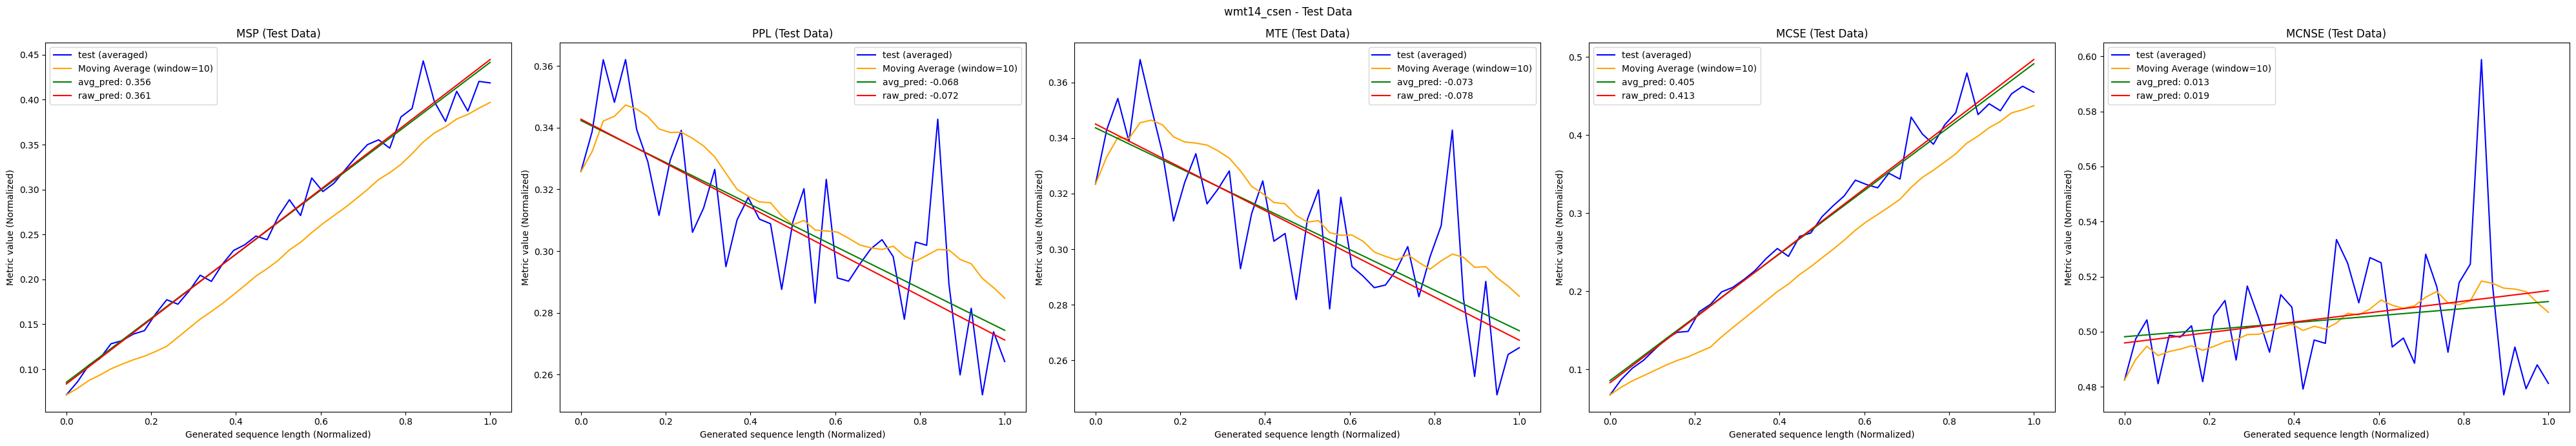

Loading NLI model...
/home/maiya.goloburda/.conda/envs/detrend/lib/python3.10/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Initializing stat calculators...
Initializing InitialStateCalculator
Initializing SemanticMatrixCalculator
Initializing SemanticClassesCalculator
Initializing 

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7ff130d672b0>]


Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Initializing stat calculators...
Initializing InitialStateCalculator
Initializing SemanticMatrixCalculator
Initializing SemanticClassesCalculator
Initializing GreedyProbsCalculator
Initializing EntropyCalculator
Initializing GreedyLMProbsCalculator
Initializing SamplingGenerationCalculator
Initializing BartScoreCalculator
Initializing ModelScoreCalculat

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7ff184775780>]


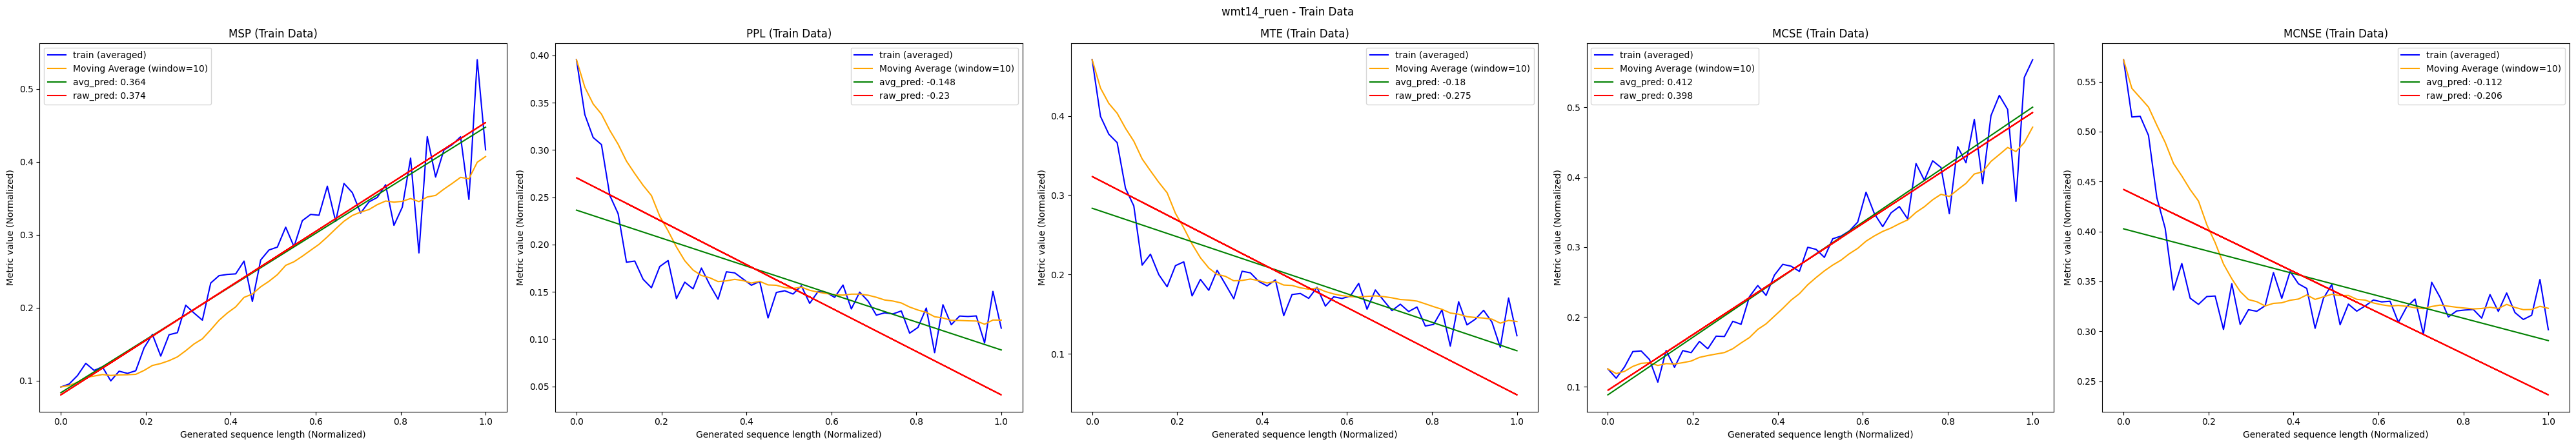

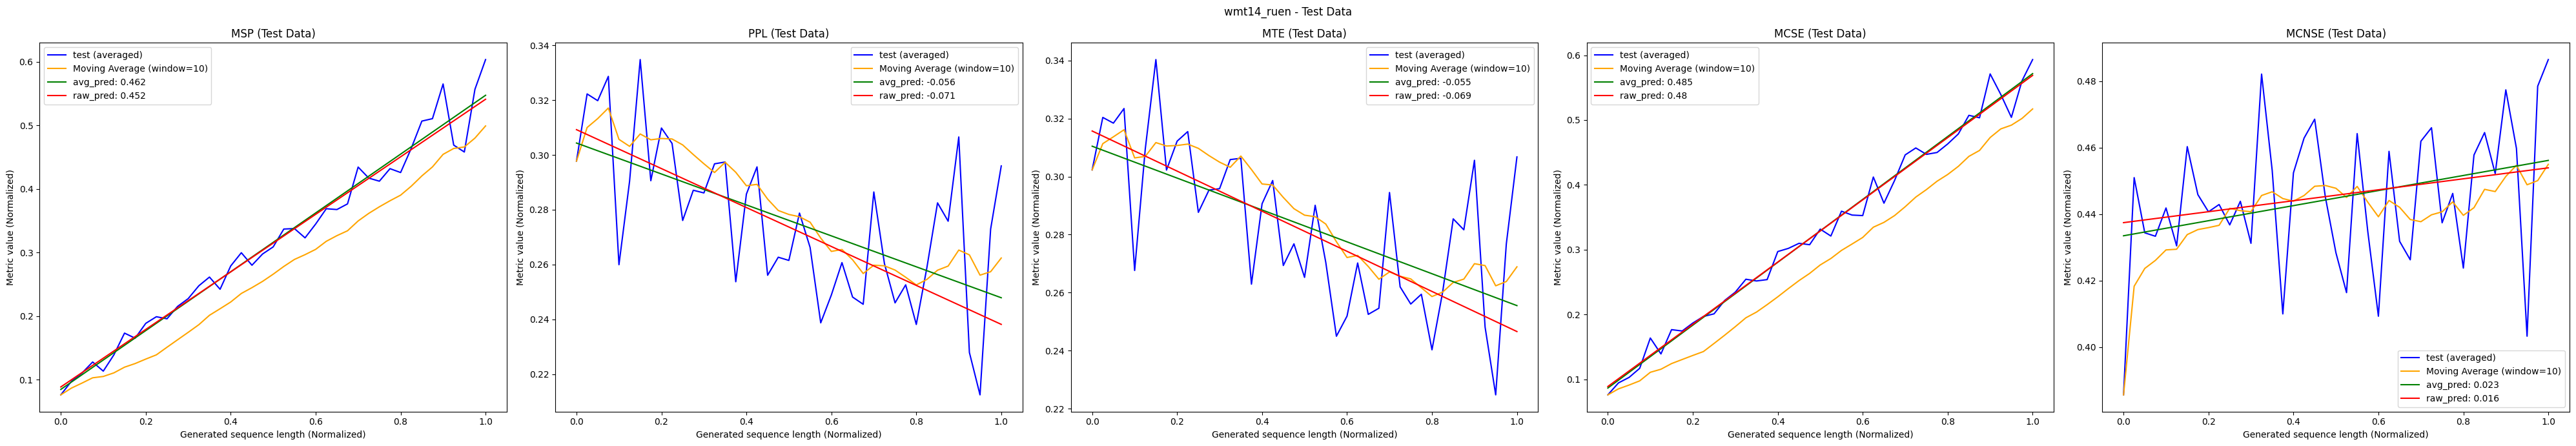

In [24]:
for dataset in DATASETS:
    train_ue_values, \
    test_ue_values, \
    train_metric_values, \
    test_metric_values, \
    train_gen_lengths, \
    test_gen_lengths = extract_and_prepare_data(dataset, methods_dict, all_metrics, model='llama1b')

    upper_q = np.quantile(train_gen_lengths, 0.95)
    lower_q = np.quantile(train_gen_lengths, 0.05)
    below_q_ids = (train_gen_lengths < upper_q) & (train_gen_lengths > lower_q)
    train_gen_lengths = train_gen_lengths[below_q_ids]

    train_normalized_metric_values = {}
    test_normalized_metric_values = {}
    all_methods = list(train_ue_values.keys())
    # Train Data Plot
    fig, axs = plt.subplots(1, len(all_methods), figsize=(8 * len(all_methods), 7))
    
    for i, metric in enumerate(all_methods):
        try:
            gen_length_scaler = MinMaxScaler()
            train_gen_lengths_normalized = gen_length_scaler.fit_transform(train_gen_lengths[:, np.newaxis]).squeeze()

            # Normalize train metrics
            train_metric = train_ue_values[metric][below_q_ids]
            scaler = MinMaxScaler()
            train_normalized_metric_values[metric] = scaler.fit_transform(train_metric[:, np.newaxis]).squeeze()

            # Average values for each unique generated sequence length
            unique_lengths = np.unique(train_gen_lengths_normalized)
            avg_train_metric_values = []
            avg_train_gen_lengths_normalized = []

            for length in unique_lengths:
                idx = np.isclose(train_gen_lengths_normalized, length)
                avg_train_metric_values.append(np.mean(train_normalized_metric_values[metric][idx]))
                avg_train_gen_lengths_normalized.append(length)

            avg_train_metric_values = np.array(avg_train_metric_values)
            avg_train_gen_lengths_normalized = np.array(avg_train_gen_lengths_normalized)

            # Compute moving average
            window_size = 10
            moving_avg = pd.Series(avg_train_metric_values).rolling(window=window_size, min_periods=1).mean()

            # Fit linear regression on averaged values
            train_linreg = sklearn.linear_model.LinearRegression()
            train_linreg.fit(avg_train_gen_lengths_normalized[:, np.newaxis], avg_train_metric_values)
            coef = train_linreg.coef_[0]

            # Fit linear regression on non-averaged data (raw data)
            raw_linreg = sklearn.linear_model.LinearRegression()
            raw_linreg.fit(train_gen_lengths_normalized[:, np.newaxis], train_normalized_metric_values[metric])

            ax = axs[i]
            ax.plot(avg_train_gen_lengths_normalized, avg_train_metric_values, label='train (averaged)', color='blue')
            ax.plot(avg_train_gen_lengths_normalized, moving_avg, label=f'Moving Average (window={window_size})', color='orange')
            ax.plot(avg_train_gen_lengths_normalized, train_linreg.predict(avg_train_gen_lengths_normalized[:, np.newaxis]), label=f'avg_pred: {round(coef, 3)}', color='green')
            ax.plot(train_gen_lengths_normalized, raw_linreg.predict(train_gen_lengths_normalized[:, np.newaxis]), label=f'raw_pred: {round(raw_linreg.coef_[0], 3)}', color='red')

            ax.legend()
            ax.set_title(f'{metric} (Train Data)')
            ax.set_xlabel('Generated sequence length (Normalized)')
            ax.set_ylabel('Metric value (Normalized)')
        except Exception as ex:
            print(f"Exception: {ex}\n values: {len(train_ue_values[metric])} , lengths: {len(train_gen_lengths)}")

    fig.suptitle(f'{dataset} - Train Data')
    plt.tight_layout()
    plt.show()

    upper_q_test = np.quantile(test_gen_lengths, 0.95)
    lower_q_test = np.quantile(test_gen_lengths, 0.05)
    below_q_ids_test = (test_gen_lengths < upper_q_test) & (test_gen_lengths > lower_q_test)
    test_gen_lengths = test_gen_lengths[below_q_ids_test]


    # Test Data Plot (Separate figure)
    fig, axs = plt.subplots(1, len(all_methods), figsize=(8 * len(all_methods), 7))
    for i, metric in enumerate(all_methods):
    # Normalize test sequence lengths using a separate MinMaxScaler for test data
        test_gen_length_scaler = MinMaxScaler()
        test_gen_lengths_normalized = test_gen_length_scaler.fit_transform(test_gen_lengths[:, np.newaxis]).squeeze()

        # Normalize test metrics using a new scaler for test data
        test_metric = test_ue_values[metric][below_q_ids_test]
        scaler_test = MinMaxScaler()
        test_normalized_metric_values[metric] = scaler_test.fit_transform(test_metric[:, np.newaxis]).squeeze()

        # Average values for each unique generated sequence length in the test data
        unique_lengths = np.unique(test_gen_lengths_normalized)
        avg_test_metric_values = []
        avg_test_gen_lengths_normalized = []

        for length in unique_lengths:
            idx = np.isclose(test_gen_lengths_normalized, length)
            avg_test_metric_values.append(np.mean(test_normalized_metric_values[metric][idx]))
            avg_test_gen_lengths_normalized.append(length)

        avg_test_metric_values = np.array(avg_test_metric_values)
        avg_test_gen_lengths_normalized = np.array(avg_test_gen_lengths_normalized)

        # Compute moving average for test data
        moving_avg_test = pd.Series(avg_test_metric_values).rolling(window=window_size, min_periods=1).mean()

        # Fit linear regression on averaged values for test data
        test_linreg = sklearn.linear_model.LinearRegression()
        test_linreg.fit(avg_test_gen_lengths_normalized[:, np.newaxis], avg_test_metric_values)
        coef = test_linreg.coef_[0]

        # Fit linear regression on non-averaged (raw) test data
        raw_linreg_test = sklearn.linear_model.LinearRegression()
        raw_linreg_test.fit(test_gen_lengths_normalized[:, np.newaxis], test_normalized_metric_values[metric])

        ax = axs[i]
        ax.plot(avg_test_gen_lengths_normalized, avg_test_metric_values, label='test (averaged)', color='blue')
        ax.plot(avg_test_gen_lengths_normalized, moving_avg_test, label=f'Moving Average (window={window_size})', color='orange')
        ax.plot(avg_test_gen_lengths_normalized, test_linreg.predict(avg_test_gen_lengths_normalized[:, np.newaxis]), label=f'avg_pred: {round(coef, 3)}', color='green')
        ax.plot(avg_test_gen_lengths_normalized, raw_linreg_test.predict(avg_test_gen_lengths_normalized[:, np.newaxis]), label=f'raw_pred: {round(raw_linreg_test.coef_[0], 3)}', color='red')

        ax.legend()
        ax.set_title(f'{metric} (Test Data)')
        ax.set_xlabel('Generated sequence length (Normalized)')
        ax.set_ylabel('Metric value (Normalized)')

    fig.suptitle(f'{dataset} - Test Data')
    plt.tight_layout()
    plt.show()



In [4]:
import numpy as np
import sklearn.linear_model

n_bootstrap = 1000  # Number of bootstrap samples
bootstrap_results = {}

for dataset in DATASETS:
    train_ue_values, \
    test_ue_values, \
    train_metric_values, \
    test_metric_values, \
    train_gen_lengths, \
    test_gen_lengths = extract_and_prepare_data(dataset, methods_dict, all_metrics, model='llama1b')

    upper_q = np.quantile(train_gen_lengths, 0.95)
    lower_q = np.quantile(train_gen_lengths, 0.05)
    below_q_ids = (train_gen_lengths < upper_q) & (train_gen_lengths > lower_q)
    train_gen_lengths = train_gen_lengths[below_q_ids]

    train_normalized_metric_values = {}
    all_methods = list(train_ue_values.keys())

    dataset_results = {}

    for metric in all_methods:
        try:
            # Normalize sequence lengths
            gen_length_scaler = MinMaxScaler()
            train_gen_lengths_normalized = gen_length_scaler.fit_transform(train_gen_lengths[:, np.newaxis]).squeeze()

            # Normalize metric values
            train_metric = train_ue_values[metric][below_q_ids]
            scaler = MinMaxScaler()
            train_normalized_metric_values[metric] = scaler.fit_transform(train_metric[:, np.newaxis]).squeeze()

            # Bootstrap Linear Regression Coefficients
            bootstrap_coefs = []
            for _ in range(n_bootstrap):
                boot_idx = np.random.choice(len(train_gen_lengths_normalized), size=len(train_gen_lengths_normalized), replace=True)
                boot_x = train_gen_lengths_normalized[boot_idx]
                boot_y = train_normalized_metric_values[metric][boot_idx]

                boot_model = sklearn.linear_model.LinearRegression()
                boot_model.fit(boot_x[:, np.newaxis], boot_y)
                bootstrap_coefs.append(boot_model.coef_[0])

            bootstrap_coefs = np.array(bootstrap_coefs)
            mean_coef = np.mean(bootstrap_coefs)
            std_coef = np.std(bootstrap_coefs)
            ci_lower, ci_upper = np.percentile(bootstrap_coefs, [2.5, 97.5])

            dataset_results[metric] = {
                "mean_coef": mean_coef,
                "std_coef": std_coef,
                "95%_CI": (ci_lower, ci_upper),
                "all_bootstrap_coefs": bootstrap_coefs  # Store full bootstrap distribution if needed
            }

        except Exception as ex:
            print(f"Exception: {ex}\n values: {len(train_ue_values[metric])} , lengths: {len(train_gen_lengths)}")

    bootstrap_results[dataset] = dataset_results

# Display final results
for dataset, results in bootstrap_results.items():
    print(f"\nDataset: {dataset}")
    for metric, stats in results.items():
        print(f"  Metric: {metric}")
        print(f"    Mean Coef: {stats['mean_coef']:.3f}")
        print(f"    Std Dev Coef: {stats['std_coef']:.3f}")
        print(f"    95% CI: ({stats['95%_CI'][0]:.3f}, {stats['95%_CI'][1]:.3f})")


Loading NLI model...


/home/maiya.goloburda/.conda/envs/detrend/lib/python3.10/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Initializing stat calculators...
Initializing InitialStateCalculator
Initializing SemanticMatrixCalculator
Initializing SemanticClassesCalculator
Initializing GreedyProbsCalculator

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7f34422469b0>]


Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Initializing stat calculators...
Initializing InitialStateCalculator
Initializing SemanticMatrixCalculator
Initializing SemanticClassesCalculator
Initializing GreedyProbsCalculator
Initializing EntropyCalculator
Initializing GreedyLMProbsCalculator
Initializing SamplingGenerationCalculator
Initializing BartScoreCalculator
Initializing ModelScoreCalculat

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7f3440091690>]


Loading NLI model...
/home/maiya.goloburda/.conda/envs/detrend/lib/python3.10/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Initializing stat calculators...
Initializing InitialStateCalculator
Initializing SemanticMatrixCalculator
Initializing SemanticClassesCalculator
Initializing 

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7f34400930d0>]


Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Initializing stat calculators...
Initializing InitialStateCalculator
Initializing SemanticMatrixCalculator
Initializing SemanticClassesCalculator
Initializing GreedyProbsCalculator
Initializing EntropyCalculator
Initializing GreedyLMProbsCalculator
Initializing SamplingGenerationCalculator
Initializing BartScoreCalculator
Initializing ModelScoreCalculat

Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7f3442246e00>]

Dataset: wmt14_csen
  Metric: MSP
    Mean Coef: 0.470
    Std Dev Coef: 0.010
    95% CI: (0.450, 0.490)
  Metric: PPL
    Mean Coef: -0.051
    Std Dev Coef: 0.009
    95% CI: (-0.069, -0.033)
  Metric: MTE
    Mean Coef: -0.061
    Std Dev Coef: 0.009
    95% CI: (-0.079, -0.043)
  Metric: MCSE
    Mean Coef: 0.495
    Std Dev Coef: 0.009
    95% CI: (0.477, 0.514)
  Metric: MCNSE
    Mean Coef: 0.029
    Std Dev Coef: 0.014
    95% CI: (0.002, 0.056)

Dataset: wmt14_ruen
  Metric: MSP
    Mean Coef: 0.373
    Std Dev Coef: 0.011
    95% CI: (0.351, 0.395)
  Metric: PPL
    Mean Coef: -0.230
    Std Dev Coef: 0.012
    95% CI: (-0.254, -0.206)
  Metric: MTE
    Mean Coef: -0.275
    Std Dev Coef: 0.013
    95% CI: (-0.300, -0.247)
  Metric: MCSE
    Mean Coef: 0.398
    Std Dev Coef: 0.010
    95% CI: (0.379, 0.420)
  Metric: MCNSE
    Mean Coef: -0.206
    Std Dev Coef: 